## Creating a EfficientNetB3 with actual data

In [1]:
#Lets import all packages again just that we have everything we need

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # important to avoir an error (the truncated picture error)
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
X_train = np.load("processed/X_train.npy")
X_test = np.load("processed/X_test.npy")
y_train = np.load("processed/y_train.npy")
y_test = np.load("processed/y_test.npy")

#### Plotting images to see if our data is correct

/Users/alex/.pyenv/versions/fungai/lib/python3.10/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


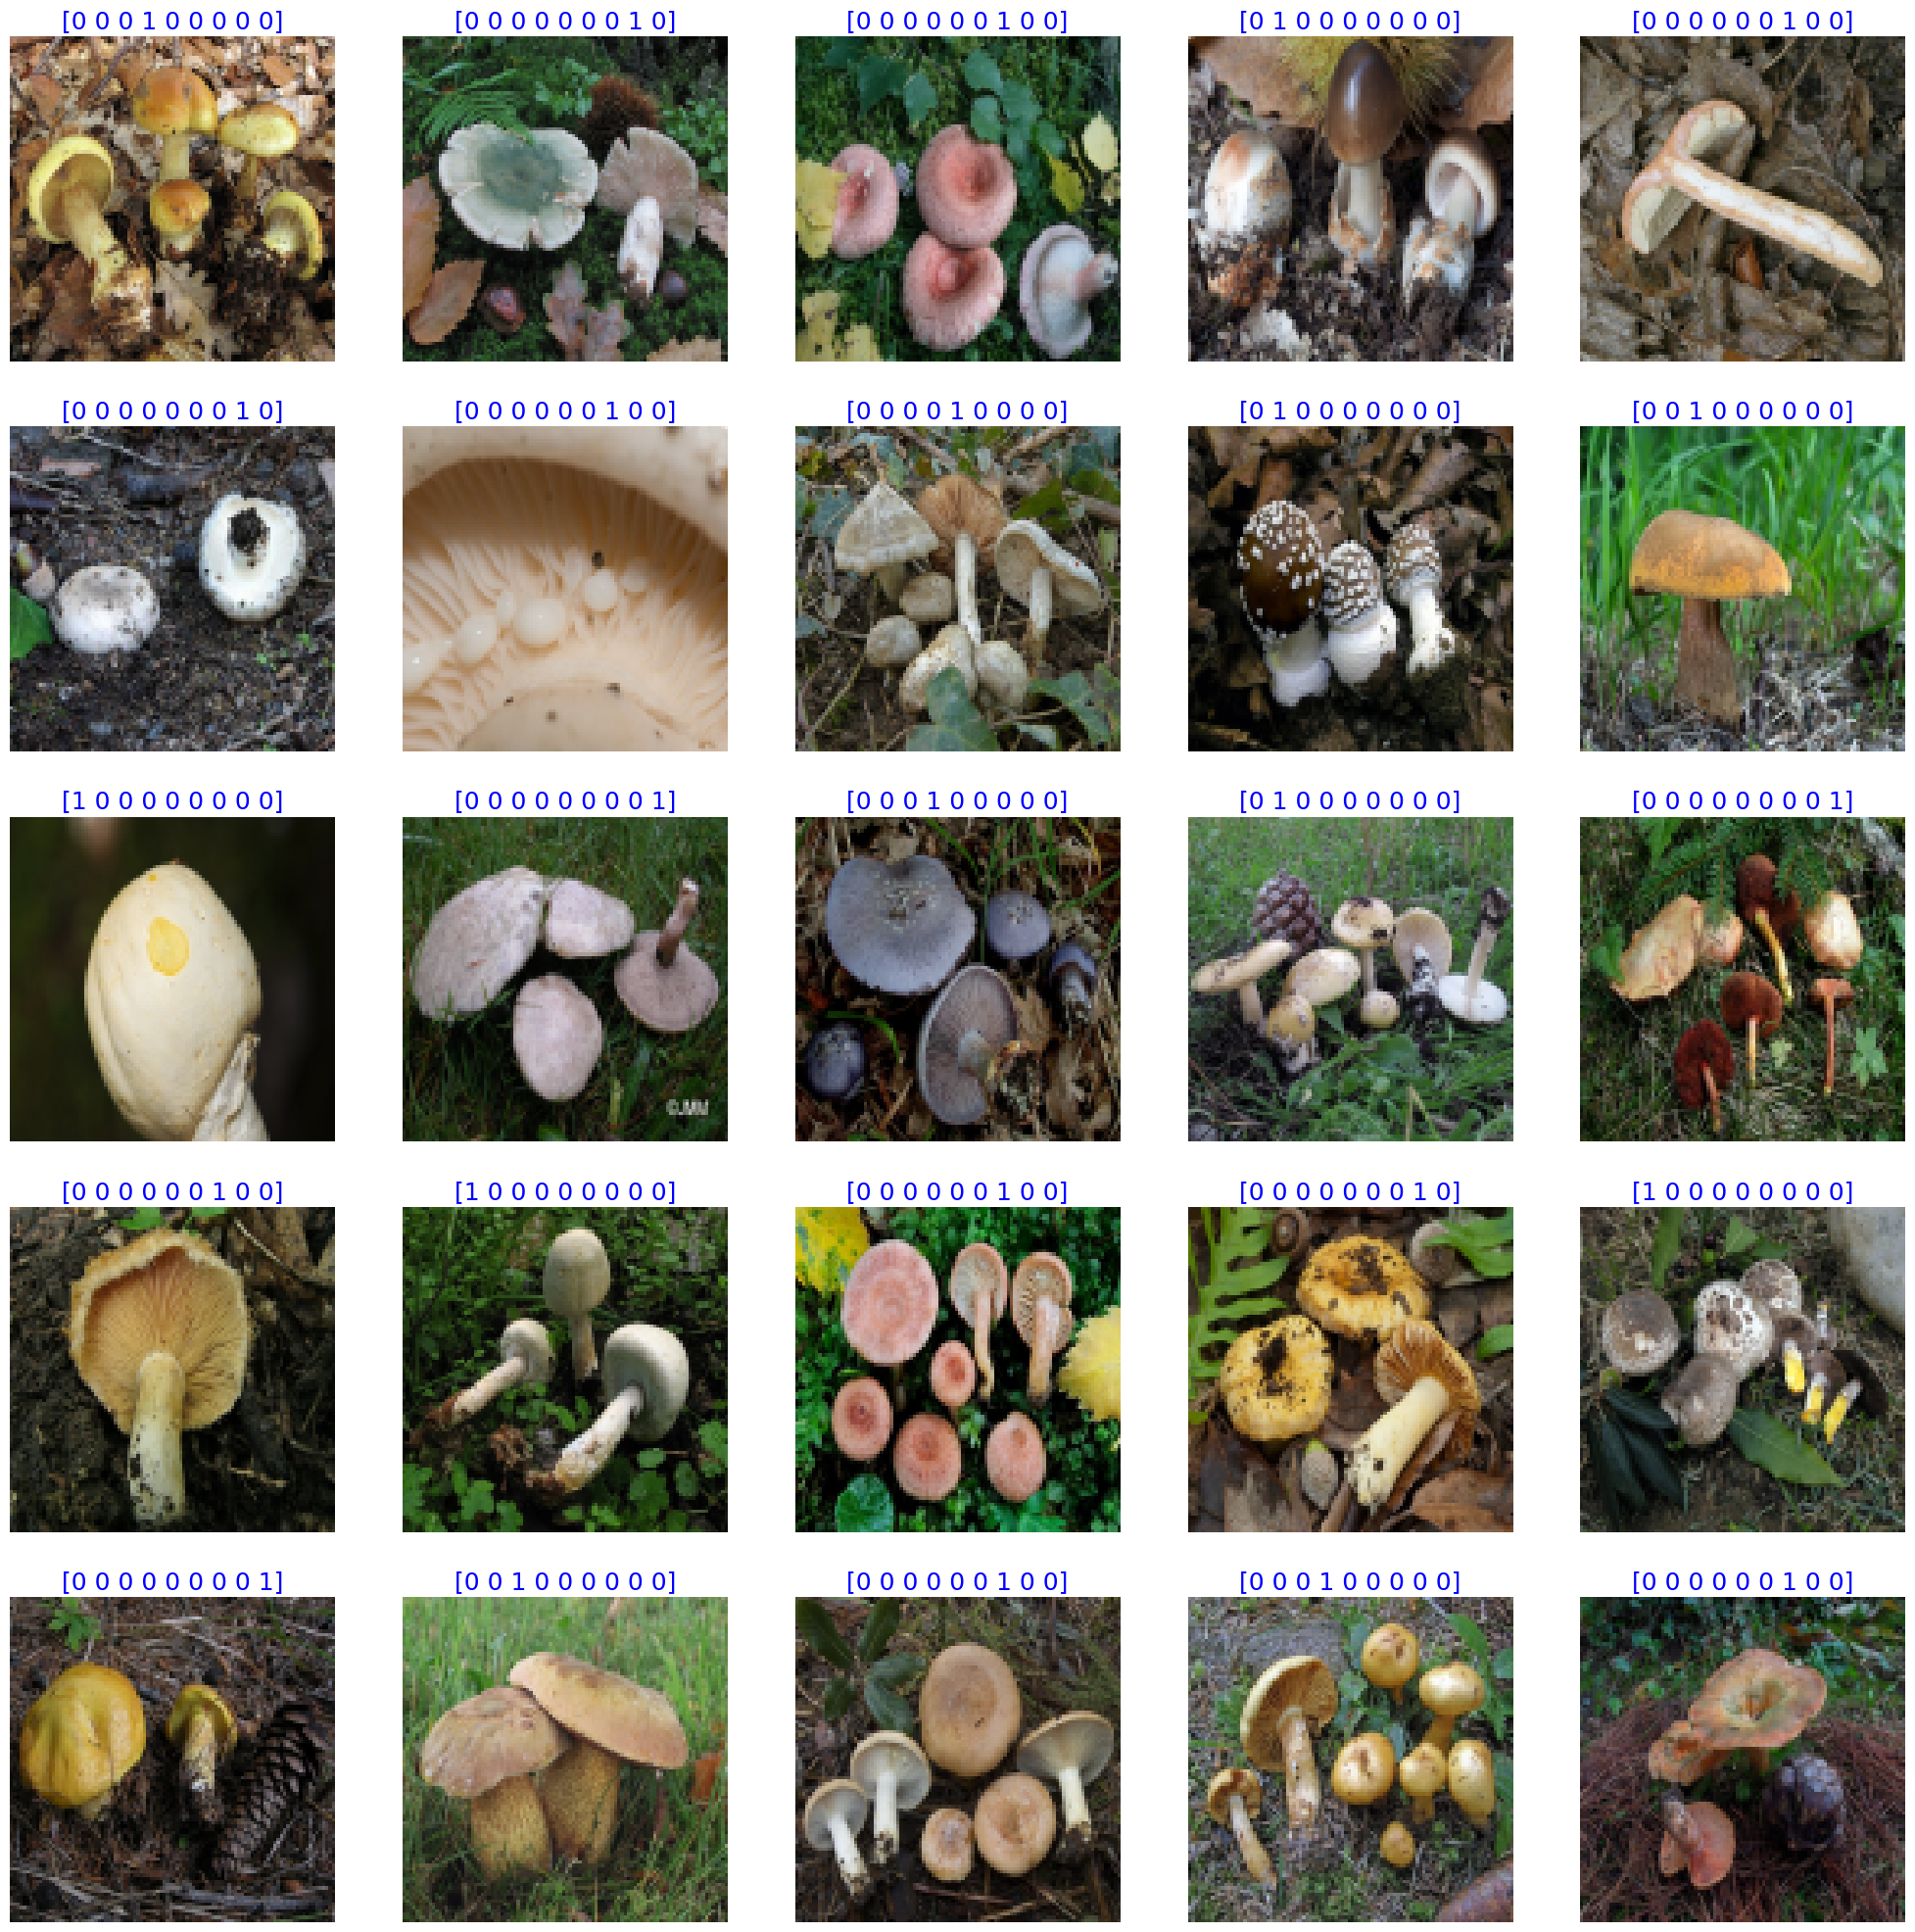

In [20]:
def show_image_samples(image,label):
    
    images,labels=image,label # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i]      
        plt.imshow(image)
        plt.title(label[i], color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(X_train,y_train)

### Creating the Model

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

In [4]:
img_size =X_train[0].shape

In [24]:
def make_model(img_size, lr, mod_num=3):  
    
    img_shape=(img_size[0], img_size[1], 3)

    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
    msg='Created EfficientNet B3 model'
   
    base_model.trainable=False
    
    x=base_model.output
    
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.08),activity_regularizer=regularizers.l2(0.05),
                    bias_regularizer=regularizers.l2(0.02) ,activation='relu')(x)
    x=Dropout(rate=0.3, seed=123)(x)       
    output=Dense(9, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 50
es = EarlyStopping(patience=3)
callbacks = [es]


In [26]:
history = model.fit(X_train,y_train, epochs=epochs, verbose=1, validation_data=(X_test,y_test), 
                    callbacks = callbacks, validation_split=0.2)

Epoch 1/50


KeyboardInterrupt: 

In [40]:
def basic_model():  

    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(100,100,3), pooling='max') 
    msg='Created EfficientNet B3 model'
   
    base_model.trainable=True
    
    return base_model





In [41]:
model = basic_model()
model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_26 (Rescaling)       (None, 100, 100, 3)  0           ['input_14[0][0]']               
                                                                                                  
 normalization_13 (Normalizatio  (None, 100, 100, 3)  7          ['rescaling_26[0][0]']           
 n)                                                                                               
                                                                                     

In [51]:
def efficientnetb3_model():
    
    base_model = basic_model()
    
    norm = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )
    flatten = Flatten()
    dense_layer = Dense(100, kernel_regularizer = regularizers.l2(l = 0.03),activity_regularizer=regularizers.l2(0.03),
                    bias_regularizer=regularizers.l2(0.03) ,activation='relu')
    dropout_layer1 =Dropout(rate=0.4, seed=123)  
    final_layer = Dense(9, activation='softmax')
    
    model = Sequential([
    base_model,
    norm,
    flatten,
    dense_layer,
    dropout_layer1,
    final_layer
    ])    
    
    model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model


model2=efficientnetb3_model() # using B3 model by default

In [52]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

In [53]:
history_2 = model2.fit(X_train,y_train, epochs=epochs, verbose=1, validation_data=(X_test,y_test), 
                    callbacks = [es], validation_split=0.2, batch_size=16)

Epoch 1/50
282/282 [==============================] - 112s 367ms/step - loss: 7.4290 - accuracy: 0.2735 - val_loss: 5.9756 - val_accuracy: 0.1472
Epoch 2/50
282/282 [==============================] - 102s 360ms/step - loss: 4.8434 - accuracy: 0.4154 - val_loss: 4.5788 - val_accuracy: 0.1679
Epoch 3/50
282/282 [==============================] - 101s 357ms/step - loss: 3.6043 - accuracy: 0.5121 - val_loss: 3.6309 - val_accuracy: 0.2402
Epoch 4/50
282/282 [==============================] - 102s 363ms/step - loss: 2.7524 - accuracy: 0.5808 - val_loss: 3.0700 - val_accuracy: 0.2501
Epoch 5/50
282/282 [==============================] - 104s 368ms/step - loss: 2.1759 - accuracy: 0.6364 - val_loss: 2.7459 - val_accuracy: 0.3160
Epoch 6/50
282/282 [==============================] - 104s 369ms/step - loss: 1.7531 - accuracy: 0.7098 - val_loss: 2.1931 - val_accuracy: 0.4826
Epoch 7/50
282/282 [==============================] - 106s 376ms/step - loss: 1.4424 - accuracy: 0.7525 - val_loss: 2.5122 -

In [54]:
model2.evaluate(X_test,y_test)

70/70 [==============================] - 10s 148ms/step - loss: 1.7713 - accuracy: 0.5521


[1.7713285684585571, 0.552144467830658]

### Using Data Aug